### Setup and imports

In [1]:
import time

import numpy as np
import scipy as sp
import scipy.stats
import tensorflow as tf
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline
from IPython.display import HTML, display

from gcn.models import GCN
from gcn import utils as gcn_utils

### Network drawing routines

In [2]:
def network_colors(features, ref_nodes=[], fmin=0.0, fmax=1.0):
    # Generate colormap
    cmap = mpl.cm.get_cmap('viridis')
    norm = mpl.colors.Normalize(vmin=fmin, vmax=fmax)
    
    # Compute colors
    edgecolors = cmap(norm(np.round(features)))
    edgecolors[ref_nodes] = [1, 0, 0, 1]
    node_colors = cmap(norm(features))
    
    return node_colors, edgecolors

_network_layouts = {}
def draw_network(g, features=None, ref_nodes=[], fmin=0.0, fmax=1.0, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    else:
        fig = ax.figure
    
    if g not in _network_layouts:
        _network_layouts[g] = nx.drawing.layout.spring_layout(g)
    layout = _network_layouts[g]
    
    if features is None:
        assert len(ref_nodes) == 0
        nx.draw_networkx(g, pos=layout, ax=ax, node_color='#65cb5e')
        node_collection = None
        edge_collection = None
        text_items = None
    else:
        # Plot nodes, edges and labels
        node_colors, edgecolors = network_colors(features, ref_nodes=ref_nodes, fmin=fmin, fmax=fmax)
        node_collection = nx.draw_networkx_nodes(g, pos=layout, ax=ax,
                                                 node_color=node_colors,
                                                 edgecolors=edgecolors,
                                                 linewidths=2)
        edge_collection = nx.draw_networkx_edges(g, pos=layout, ax=ax)
        text_items = nx.draw_networkx_labels(g, pos=layout, font_color='#e4e4e4', ax=ax)
        
        # Add the colorbar
        color_sm = plt.cm.ScalarMappable(cmap='viridis', norm=mpl.colors.Normalize(vmin=fmin, vmax=fmax))
        color_sm.set_array([])
        fig.colorbar(color_sm)
    
    return (fig, ax), (node_collection, edge_collection, text_items)

**Random graphs generators:**
* [Planted Partition](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.generators.community.planted_partition_graph.html#networkx.generators.community.planted_partition_graph)
* [Lancichinetti–Fortunato–Radicchi benchmark](https://en.wikipedia.org/wiki/Lancichinetti%E2%80%93Fortunato%E2%80%93Radicchi_benchmark)

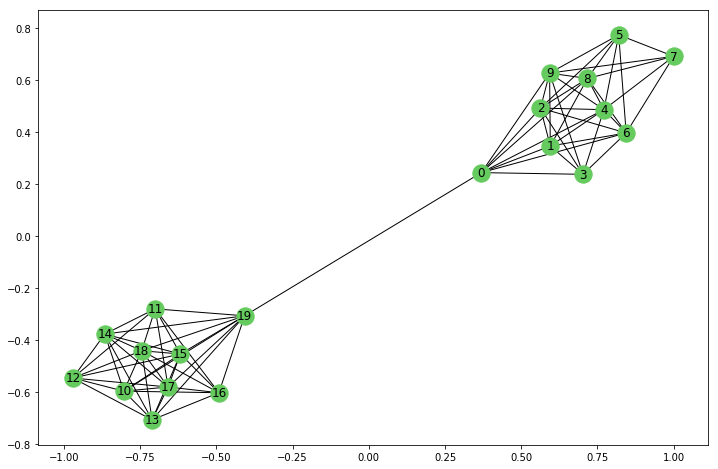

In [3]:
l = 2
k = 10
N = l * k
g = nx.planted_partition_graph(l, k, .9, .01)
draw_network(g);

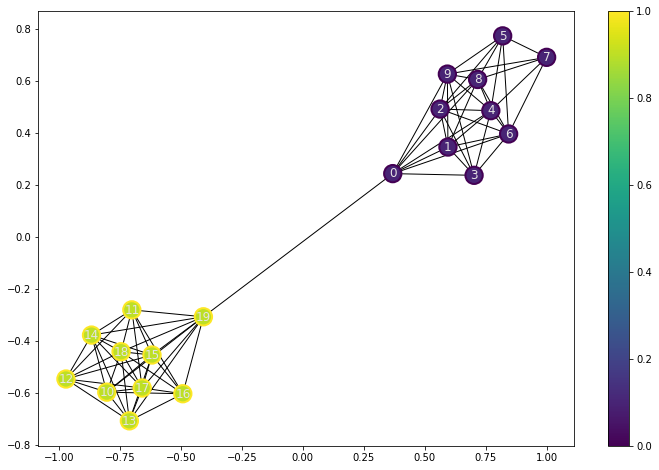

In [4]:
labels = np.stack([[.9, .1]] * (N // 2) + [[.1, .9]] * (N // 2))
draw_network(g, features=labels[:, 1]);

### Try out feature randomisation

In [5]:
def feature_sample(mode, scale=.2, size=None):
    #α = alpha
    #β = (α - 1) / mode - α + 2
    #return np.random.beta(α, β, size=size)
    return np.random.normal(mode, scale, size=size)

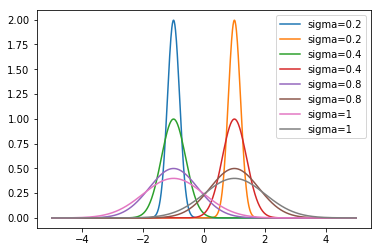

In [6]:
for sigma in [.2, .4, .8, 1]:
    x = np.linspace(-5, 5, 1000)
    np.c_
    plt.plot(x, np.c_[scipy.stats.norm.pdf(x, -1, sigma), scipy.stats.norm.pdf(x, 1, sigma)],
             label='sigma={}'.format(sigma))
    #plt.hist(feature_sample(1, i, size=1000), normed=True, bins=50, alpha=.6)
plt.legend()

### Train the GCN

#### Initial setup

Base options for the model

In [7]:
flags = tf.app.flags
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 16, 'Number of units in hidden layer 1.')
flags.DEFINE_float('dropout', 0, #0.5,
                   'Dropout rate (1 - keep probability).')
flags.DEFINE_float('weight_decay', 0, #5e-4,
                   'Weight for L2 loss on embedding matrix.')
flags.DEFINE_integer('early_stopping', 10, 'Tolerance for early stopping (# of epochs).')

In [8]:
def initialise_arrays(training_nodes, labels, mult=5):
    # Generate initial noised features
    features_noise = np.stack([np.concatenate([feature_sample(2 * v - 1, size=mult) for v in label_values])
                               for label_values in labels])
    features = gcn_utils.preprocess_features(sp.sparse.lil_matrix(features_noise))

    # Generate training and validation arrays
    train_mask = gcn_utils.sample_mask(training_nodes, labels.shape[0])
    val_mask = np.logical_not(train_mask)

    labels_train = np.zeros(labels.shape)
    labels_val = np.zeros(labels.shape)

    labels_train[train_mask, :] = labels[train_mask, :]
    labels_val[val_mask, :] = labels[val_mask, :]
    
    return {
        'features': features,
        'train_mask': train_mask,
        'val_mask': val_mask,
        'labels': labels,
        'labels_train': labels_train,
        'labels_val': labels_val,
    }

In [9]:
def initialise_model_session(g, training_nodes, labels, mult=5):
    arrays = initialise_arrays(training_nodes, labels, mult=mult)
    
    # Finish parameterising the model
    support = [gcn_utils.preprocess_adj(nx.adjacency_matrix(g))]
    placeholders = {
        'support': [tf.sparse_placeholder(tf.float32) for _ in range(len(support))],
        'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(arrays['features'][2], dtype=tf.int64)),
        'labels': tf.placeholder(tf.float32, shape=(None, arrays['labels_train'].shape[1])),
        'labels_mask': tf.placeholder(tf.int32),
        'dropout': tf.placeholder_with_default(0., shape=()),
        'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
    }
    arrays['support'] = support
    arrays['placeholders'] = placeholders
    
    model = GCN(placeholders, input_dim=arrays['features'][2][1], logging=True)
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    
    return model, arrays, session

In [10]:
def evaluate_model(model, arrays, session):
    t_test = time.time()
    feed_dict_val = gcn_utils.construct_feed_dict(arrays['features'], arrays['support'],
                                                  arrays['labels_train'], arrays['train_mask'],
                                                  arrays['placeholders'])
    outs_val = session.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)

def model_predict(model, arrays, session):
    feed_dict_pred = gcn_utils.construct_feed_dict(arrays['features'], arrays['support'],
                                                   arrays['labels'], np.ones(arrays['labels'].shape[0]),
                                                   arrays['placeholders'])
    return session.run(model.predict(), feed_dict=feed_dict_pred)

#### Model training

In [11]:
def legend_text(epoch, t, train_loss, train_acc, val_loss, val_acc):
    return ("epoch: {:4d} time={:.5f}\n"
            "train_loss={:.5f} train_acc={:.5f}\n"
            "val_loss={:.5f} val_acc={:.5f}\n").format(epoch, time.time() - t,
                                                       train_loss, train_acc, val_loss, val_acc)

def build_train_animation(g, training_nodes, labels):
    # Get the model
    model, arrays, session = initialise_model_session(g, training_nodes, labels)
    
    # Prepare plotting
    (fig, ax), (node_collection, _, _) = draw_network(g, features=labels[:, 1],
                                                      ref_nodes=np.where(arrays['train_mask'])[0])
    legend = ax.text(.5, 1, legend_text(0, 0, 0, 0, 0, 0),
                     ha='center', va='bottom', transform=ax.transAxes,
                     bbox=dict(facecolor='white', alpha=0.8))
    
    def init_plot():
        legend.set_text(legend_text(0, 0, 0, 0, 0, 0))
        node_collection.set_color(np.zeros((labels.shape[0], 4)))
        node_collection.set_edgecolors(np.zeros((labels.shape[0], 4)))
        return node_collection, legend

    cost_val = []
    def train_step(frame):
        t = time.time()

        feed_dict = gcn_utils.construct_feed_dict(arrays['features'], arrays['support'],
                                                  arrays['labels_train'], arrays['train_mask'],
                                                  arrays['placeholders'])
        feed_dict.update({arrays['placeholders']['dropout']: flags.FLAGS.dropout})

        outs = session.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
        cost, acc, duration = evaluate_model(model, arrays, session)
        cost_val.append(cost)

        #print("Epoch:", '%04d' % (frame + 1), "train_loss={:.5f}".format(outs[1]),
        #      "train_acc={:.5f}".format(outs[2]), "val_loss={:.5f}".format(cost),
        #      "val_acc={:.5f}".format(acc), "time={:.5f}".format(time.time() - t))
        
        legend.set_text(legend_text(frame, t, outs[1], outs[2], cost, acc))
        
        preds = model_predict(model, arrays, session)
        node_colors, edgecolors = network_colors(preds[:, 1], ref_nodes=np.where(arrays['train_mask'])[0])
        node_collection.set_color(node_colors)
        node_collection.set_edgecolors(edgecolors)

        return node_collection, legend

    def model_frames():
        counter = 0
        while True:
            if (counter > flags.FLAGS.early_stopping and
                    cost_val[-1] > np.mean(cost_val[-(flags.FLAGS.early_stopping+1):-1])):
                #print("Early stopping.")
                return
            else:
                yield counter
                counter += 1

    anim = mpl.animation.FuncAnimation(fig, train_step, blit=True,
                                       init_func=init_plot,
                                       interval=10,
                                       save_count=1000,
                                       frames=model_frames(),
                                       repeat=False)
    plt.close()
    return anim, (model, arrays, session)

Training animation:


Reference features:


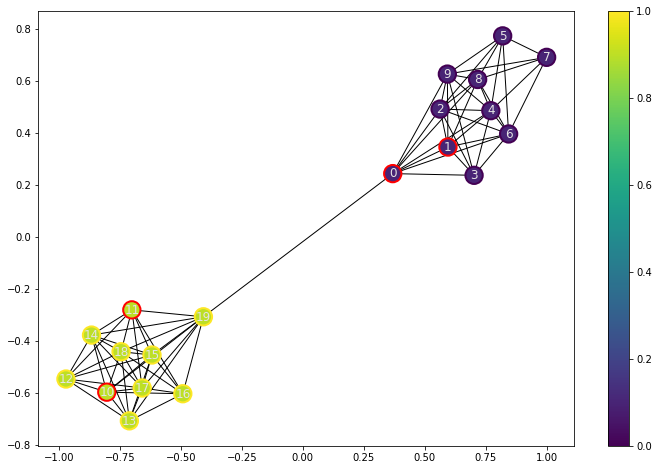

In [12]:
anim, (model, arrays, session) = build_train_animation(g, [0, 1, 10, 11], labels)
widget = anim.to_jshtml() #.to_html5_video()
print("Training animation:")
display(HTML(widget))
print("Reference features:")
draw_network(g, features=labels[:, 1], ref_nodes=np.where(arrays['train_mask'])[0]);